In [231]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from dotenv import load_dotenv
from langsmith import Client

load_dotenv()
client = Client()

In [232]:
class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: Annotated[str ,"부동산 유형 (예: 아파트, 상가)"]
    keywordlist: Annotated[List[Dict] ,"키워드 리스트"]
    messages: Annotated[list, add_messages]
    query: Annotated[str ,"생성된 SQL 쿼리"]
    results: Annotated[List[Dict], "쿼리 결과"]
    answers: Annotated[List[str], "최종 답변 결과"]

In [233]:
from langgraph.graph import StateGraph, START, END
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# Step 2: StateGraph 정의
workflow = StateGraph(RealEstateState)

In [234]:
def filter_node(state:RealEstateState) -> RealEstateState:
    system_prompt = """
    Classify if a given question is related to real estate. If the question is related to topics such as property transactions, rental conditions, location recommendations, or property features, return Pass. If it's not directly related to real estate, return Fail.

    # Output Format
    - Return Pass if the question is real estate-related, otherwise return Fail.

    # Examples
    - 입력: '서울 아파트 매매 가격이 어떻게 되나요?'
      출력: Pass

    - 입력: '이 동네 전세 시세 알려주세요'
      출력: Pass

    - 입력: '서울에서 월세 계약 조건이 어떻게 되나요?'
      출력: Pass

    - 입력: '서울 아파트 매매가 얼마인가요?'
      출력: Pass

    - 입력: '대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘'
      출력: Pass

    - 입력: '여자 혼자 살기 좋은 곳 추천해줘'
      출력: Pass

    - 입력: '교통이 편리하고 저렴한 원룸 추천해줘'
      출력: Pass

    - 입력: '이 음식점이 맛있나요?'
      출력: Fail

    - 입력: '서울에서 가장 큰 공원이 어디인가요?'
      출력: Fail
    """
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    real_estate_type = response.content.strip()
    return RealEstateState(real_estate_type=real_estate_type)

In [235]:
def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "Pass":
        return "Pass"
    else:
        return 'Fail'

In [236]:
def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("""[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
          부동산 관련 질문을 좀 더 자세하게 작성해주시면 답변드리겠습니다!!!""")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(messages=new_question)

In [237]:
import json

def extract_keywords_based_on_db(state: RealEstateState) -> RealEstateState:
    system_prompt = """
    Extract relevant keywords from a user's question based on the database schema. Match the keywords to the following categories and their corresponding tables/columns:

    1. **Location**:
    - Table: `Location`
    - Columns: `sido`, `sigungu`, `dong`

    2. **Property Type**:
    - Table: `Property`
    - Column: `property_type` (e.g., apartment, villa, officetel)

    3. **Price**:
    - Tables: `Sale`, `Rental`
    - Columns: `price`, `deposit`, `monthly_rent`

    4. **Transaction Type**:
    - Tables: `Sale`, `Rental`
    - Columns: `rental_type` (e.g., 매매, 전세, 월세)

    5. **Property Features**:
    - Table: `Property`
    - Columns: `room_count`, `bathroom_count`, `parking_count`, `exclusive_area`, `floor`

    6. **User Preferences**:
    - Table: `User`
    - Columns: `desired_location`, `age`, `gender`

    7. **Cultural/Facilities**:
    - Tables: `Cultural Facility`, `Cultural Festival`
    - Columns: `facility_name`, `festival_name`

    8. **Safety and Crime Data**:
    - Table: `Crime Stats`
    - Columns: `crime_category`, `crime_rate`

    # Output Format
    Return the extracted keywords in JSON format with the following keys:
    - "Location"
    - "Property Type"
    - "Price"
    - "Transaction Type"
    - "Property Features"
    - "User Preferences"
    - "Cultural/Facilities"
    - "Safety and Crime Data"

    If a category is not mentioned, return "없음".

    # Examples
    - Input: "서울 강남구에 있는 3억 이하 전세 아파트 찾아줘"
    Output: {
        "Location": "서울 강남구",
        "Property Type": "아파트",
        "Price": "3억 이하",
        "Transaction Type": "전세",
        "Property Features": "없음",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "없음"
    }

    - Input: "용산구에서 안전한 주택 찾고 싶어요"
    Output: {
        "Location": "용산구",
        "Property Type": "주택",
        "Price": "없음",
        "Transaction Type": "없음",
        "Property Features": "없음",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "안전"
    }

    - Input: "화장실 2개, 방 3개 있는 집 알려줘"
    Output: {
        "Location": "없음",
        "Property Type": "없음",
        "Price": "없음",
        "Transaction Type": "없음",
        "Property Features": "화장실 2개, 방 3개",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "없음"
    }
    """

    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["messages"][-1].content)
    ])
    
    extracted_keywords = response.content.strip()
    result = json.loads(extracted_keywords)
    return RealEstateState(keywordlist=result)



In [238]:
def re_questions_keywords(state: RealEstateState) -> RealEstateState:
    
    user_keywords = state["keywordlist"]
    
    if user_keywords["Location"] == "없음":
        print("=================================")
        print("""[re_questions_keywords] 질문에 지역정보가 없습니다!!! 지역 정보를 포함하여 써주시면 더 좋은 답변을 드립니다!!""")
        new_question = input("새로운 부동산 질문을 입력해주세요: ")
        print("=================================")
        return RealEstateState(messages=new_question)
    
    elif user_keywords["Transaction Type"] == "없음":
        print("=================================")
        print("""[re_questions_keywords] 질문에 부동산 유형 정보(매매, 전세, 월세)가 없습니다!!! 부동산 유형 정보를 포함하여 써주시면 더 좋은 답변을 드립니다!!""")
        new_question = input("새로운 부동산 질문을 입력해주세요: ")
        print("=================================")
        return RealEstateState(messages=new_question)
    
    elif user_keywords['Price'] == '없음':
        print("=================================")
        print("""[re_questions_keywords] 질문에 가격 정보가 없습니다!!! 가격 정보를 포함하여 써주시면 더 좋은 답변을 드립니다!!""")
        new_question = input("새로운 부동산 질문을 입력해주세요: ")
        print("=================================")
        return RealEstateState(messages=new_question)

In [239]:
def keyword_router(state: RealEstateState)-> RealEstateState: 
    # This is the router
    user_keywords = state["keywordlist"]
    
    if user_keywords['Location'] != "없음" and user_keywords['Transaction Type'] != "없음" and user_keywords['Price'] != "없음":
        if user_keywords['Transaction Type'] == '매매':
            return '매매'
        elif user_keywords['Transaction Type'] == '전세':
            return '전세'
        else:
            return '월세'
    else:
        return 'Fail'

In [240]:
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None
    
    
# DB 파일 경로 지정
db_path = './data/real_estate_(1).db'
engine = get_db_engine(db_path)
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)


In [241]:
def rental(state: RealEstateState) -> RealEstateState:
    rentals = db.get_table_info(table_names=["rentals", "property_info", "property_locations"])

    rental_prompt = """
    사용 가능한 테이블 스키마:
    {rentals}

    당신은 SQL 전문가입니다. 
    데이터베이스는 {dialect} 방언을 사용합니다.

    다음 규칙을 따라주세요:
        1. 한국어로 응답해주세요.
        2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
        3. 결과는 최대 {top_k}개까지만 보여주세요.
        4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다.
        5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
        6. rental_type 값은 다음과 같습니다:
        - 'MONTHLY': 전세
        - 'YEARLY': 월세
        7. 반드시 SELECT문에 포함되어야 하는 필드는 다음과 같습니다:
        - `l.sigungu` (시/군/구)
        - `p.description` (부동산 설명)
        - `r.deposit` (보증금)
        - `l.latitude` (위도)
        - `l.longitude` (경도)
        8. 필요한 경우 조건을 추가로 명시하세요:
        - 지역 (l.sigungu, l.dong)
        - 가격 조건 (r.deposit, r.monthly_rent)
        - 거래 유형 (r.rental_type)
        - 기타 사용자 요청 사항 (e.g., 방 개수, 전용 면적)
        9. rental_type 값이 없는 경우 전체 결과를 반환하지만, 사용자가 조건을 명시했으면 해당 조건을 반드시 반영하세요.
        10. 결과가 없을 경우 적절한 이유를 설명하고 대체 쿼리를 작성하세요.
        11. '전세', '월세' 등의 거래 조건에 따라 적절히 필터링하세요.
        12. `CAST(... AS DECIMAL)` 대신 `CAST(... AS INTEGER)`를 사용하세요.
        13. 별도의 멘트 없이 **오직 SQL 쿼리만** 작성하세요.

    ### 예시 질문과 쿼리:

    - 질문: "서울시 강남구 10억 이하 전세를 추천해줘"

    ```sql
    SELECT 
        r.property_id,
        l.sigungu,
        p.description,
        r.deposit AS "보증금",
        l.latitude,
        l.longitude
    FROM rentals r
    JOIN property_info p ON r.property_id = p.property_id
    JOIN property_locations l ON p.property_location_id = l.property_location_id
    WHERE l.sigungu LIKE '%강남구%'
    AND r.rental_type = 'MONTHLY'
    AND CAST(REPLACE(r.deposit, ',', '') AS INTEGER) <= 100000000
    LIMIT 5;
    '''

    """
    prompt = rental_prompt.format(
        dialect="SQLite",
        top_k=5,
        rentals=rentals,
    )

    response = llm.invoke([
        SystemMessage(content=prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    llm_query = response.content

    return RealEstateState(query=llm_query)

In [242]:
def clean_sql_response(state: RealEstateState) -> RealEstateState:
    # 'query' 키는 항상 존재한다고 가정
    query = state['query']

    # 코드 블록(````sql ... `````) 제거
    if query.startswith("```sql") and query.endswith("```"):
        query = query[6:-3].strip()  # "```sql" 제거 후 앞뒤 공백 제거

    # SQL 문 끝에 세미콜론 추가 (필요시)
    if not query.strip().endswith(";"):
        query = query.strip() + ";"
        

    # 상태 업데이트
    return RealEstateState(query=query)

In [243]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def run_query(state: RealEstateState) -> RealEstateState:
    
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query"])

    return RealEstateState(results=results)

In [244]:
def answer(state: RealEstateState) -> RealEstateState:
    answers = state["results"]

    if len(answers) == 0:
        return RealEstateState(answers="검색 결과가 없습니다.")

    answer_prompt = """
    너는 글쓰는 사람이야
    Json형식에 데이터를 사람한테 보여주려고 이쁘게 바꿔주지
    """

    response = llm.invoke([SystemMessage(content=answer_prompt),
                           HumanMessage(content=answers)])

    print(response.content)

    return RealEstateState(answers=response.content)

In [245]:
workflow.add_node("Filter Question", filter_node)
workflow.add_node('Re_Questions', re_questions)
workflow.add_node('Extract Keywords', extract_keywords_based_on_db)
workflow.add_node('Re_Questions_Keywords', re_questions_keywords)
workflow.add_node('Rentals', rental)
workflow.add_node('Clean Sql Response', clean_sql_response)
workflow.add_node("Run Query", run_query)
workflow.add_node("Answer", answer)

In [246]:
from IPython.display import Image, display

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'Pass': "Extract Keywords", 'Fail': 'Re_Questions'}
)

workflow.add_conditional_edges(
    "Extract Keywords",
    keyword_router,
    { '매매': END, '전세' : 'Rentals', '월세' : 'Rentals', 'Fail': 'Re_Questions_Keywords'}
)

# START에서 'Filter Question' 노드로 엣지 추가
workflow.add_edge(START, "Filter Question")
workflow.add_edge("Re_Questions", "Filter Question")
workflow.add_edge("Re_Questions_Keywords", "Filter Question")
workflow.add_edge('Rentals', "Clean Sql Response")
workflow.add_edge('Clean Sql Response', 'Run Query')
workflow.add_edge('Run Query', "Answer")
workflow.add_edge("Answer", END)

# 그래프 컴파일
app = workflow.compile()

{'real_estate_type': 'Pass', 'keywordlist': {'Location': '사당', 'Property Type': '빌라', 'Price': '2억', 'Transaction Type': '전세', 'Property Features': '엘리베이터', 'User Preferences': '없음', 'Cultural/Facilities': '없음', 'Safety and Crime Data': '없음'}, 'messages': [HumanMessage(content='사당에 엘리베이터가 있는 빌라 전세 2억 매물 추천해줘', additional_kwargs={}, response_metadata={}, id='def18e67-fd05-4a6f-abd4-b93e8acbdded')], 'query': 'SELECT \n    r.property_id,\n    l.sigungu,\n    p.description,\n    r.deposit AS "보증금",\n    l.latitude,\n    l.longitude\nFROM rentals r\nJOIN property_info p ON r.property_id = p.property_id\nJOIN property_locations l ON p.property_location_id = l.property_location_id\nWHERE l.dong LIKE \'%사당%\'\nAND r.rental_type = \'MONTHLY\'\nAND CAST(REPLACE(r.deposit, \',\', \'\') AS INTEGER) <= 200000000\nAND p.facilities LIKE \'%엘리베이터%\'\nLIMIT 5;', 'results': '', 'answers': '검색 결과가 없습니다.'}


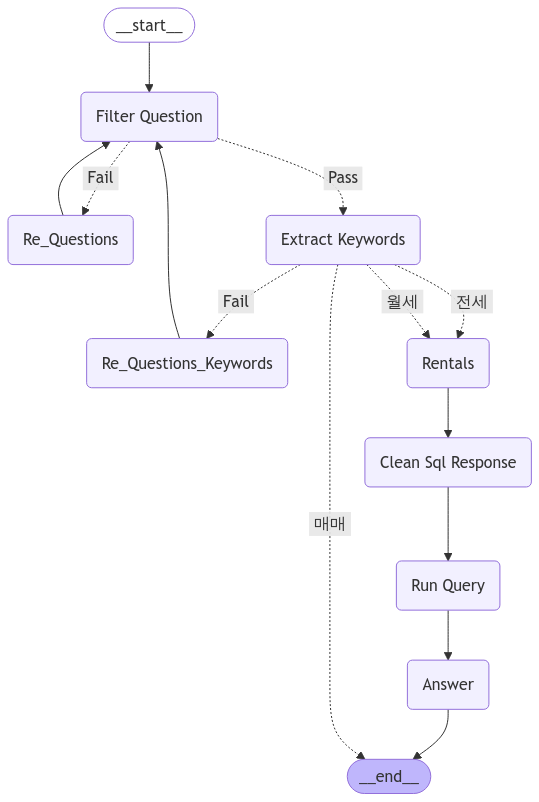

In [247]:
result = app.invoke({'messages':input()})
print(result)

workflow_image = app.get_graph().draw_mermaid_png()
display(Image(workflow_image))

In [248]:
print(result['query'])

SELECT 
    r.property_id,
    l.sigungu,
    p.description,
    r.deposit AS "보증금",
    l.latitude,
    l.longitude
FROM rentals r
JOIN property_info p ON r.property_id = p.property_id
JOIN property_locations l ON p.property_location_id = l.property_location_id
WHERE l.dong LIKE '%사당%'
AND r.rental_type = 'MONTHLY'
AND CAST(REPLACE(r.deposit, ',', '') AS INTEGER) <= 200000000
AND p.facilities LIKE '%엘리베이터%'
LIMIT 5;


In [249]:
tool = QuerySQLDataBaseTool(db=db)

In [250]:
(result['results'])

''